In [2]:
# Import standard libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_context('talk', font_scale = 1.05)

### Load data

In [3]:
df = pd.read_csv("C:\\Users\\juhic\\OneDrive\\Desktop\\DubsTech Datathon\\data.csv")
df['collection_week'] = pd.to_datetime(df['collection_week'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742253 entries, 0 to 742252
Columns: 128 entries, hospital_pk to total_staffed_pediatric_icu_beds_7_day_sum
dtypes: bool(2), datetime64[ns](1), float64(87), int64(29), object(9)
memory usage: 714.9+ MB


### Load required columns (sum only)

In [4]:
df2 = pd.read_excel("eda.xlsx", sheet_name = "columns")
df3 = pd.read_excel("eda.xlsx", sheet_name = "base_columns")

columns = list(df3['Name']) + list(df2['sum_columns'])
df = df[columns]

### Handle nulls & -9999 data records

In [5]:
df.fillna(0, inplace = True)
df.replace(to_replace = -999999, value = 2, inplace = True)

### Group by at given granularity

#### 1. State

In [6]:
# drop select base columns
drop_cols = ['hospital_pk','ccn','hospital_name','address','city','zip','hospital_subtype','fips_code',
             'is_metro_micro','geocoded_hospital_address','hhs_ids','is_corrected']
df_temp = df.drop(columns = drop_cols)

# group at state-week
df_state = df_temp.groupby(by = ['collection_week','state'], as_index = False).sum()

# sort dataframe at week level
df_state.sort_values(['state', 'collection_week'], ascending=[True, True], inplace=True)
df_state.reset_index(drop = True, inplace = True)
df_state.head()

,collection_week,state,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,...,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
0,2020-03-20,AK,324.0,0.0,0.0,72.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-03-27,AK,1783.0,0.0,0.0,586.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-04-03,AK,9304.0,0.0,0.0,3486.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-04-10,AK,8667.0,0.0,0.0,2676.0,0.0,58.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-04-17,AK,7031.0,0.0,0.0,1840.0,0.0,167.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test Split (last 12 weeks)

In [20]:
# y = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
# df_state = df_state[sum_cols]

In [7]:
df_state2 = df_state.loc[df_state['state'] == 'CA']
df_state2.drop(columns = 'state', inplace = True)

In [8]:
df_state2.set_index(keys = 'collection_week', inplace = True)
df_state2.head()

,total_beds_7_day_sum,all_adult_hospital_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_sum,inpatient_beds_used_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_pediatric_patients_hospitalized_confirmed_covid_7_day_sum,...,previous_day_admission_pediatric_covid_confirmed_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_covid_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day
collection_week,,,,,,,,,,,,,,,,,,,,,
2020-01-31,203.0,0.0,0.0,77.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,179.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,597.0,0.0,0.0,302.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-13,3555.0,0.0,0.0,1650.0,0.0,59.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-20,8237.0,0.0,0.0,3465.0,0.0,274.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# train-test split
train = df_state2[:-12]
test = df_state2[-12:]

In [12]:
model = VAR(train)
sorted_order = model.select_order(maxlags = 2)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       538.9       539.7  1.156e+234       539.3
1       482.9      513.8*  9.311e+209       495.5
2      466.7*       527.6 6.759e+204*      491.4*
-------------------------------------------------


In [ ]:
var_model = VARMAX(train, order = (2,0), enforce_stationarity = True)
fitted_model = var_model.fit(disp = False)
print(fitted_model.summary())

In [ ]:
n_forecast = 12
predict = fitted_model.get_prediction(start = len(train), end = len(train)+n_forecast-1)
predictions = predict.predicted_mean

In [ ]:
fig = plt.subplots(figsize = (18,6))
y = 'inpatient_beds_used_covid_7_day_sum'
sns.lineplot(x = test.index, y = y, data = test)
sns.lineplot(x = predictions.index, y = y, data = predictions)
plt.show()

### Check correlations

**1. First set of variables**

In [13]:
sum_cols = list(df2['sum_columns'])[5:8] + list(df2['sum_columns'])[15:17]
sum_cols

['inpatient_beds_used_covid_7_day_sum',
 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
 'total_adult_patients_hospitalized_confirmed_covid_7_day_sum',
 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum',
 'staffed_icu_adult_patients_confirmed_covid_7_day_sum']

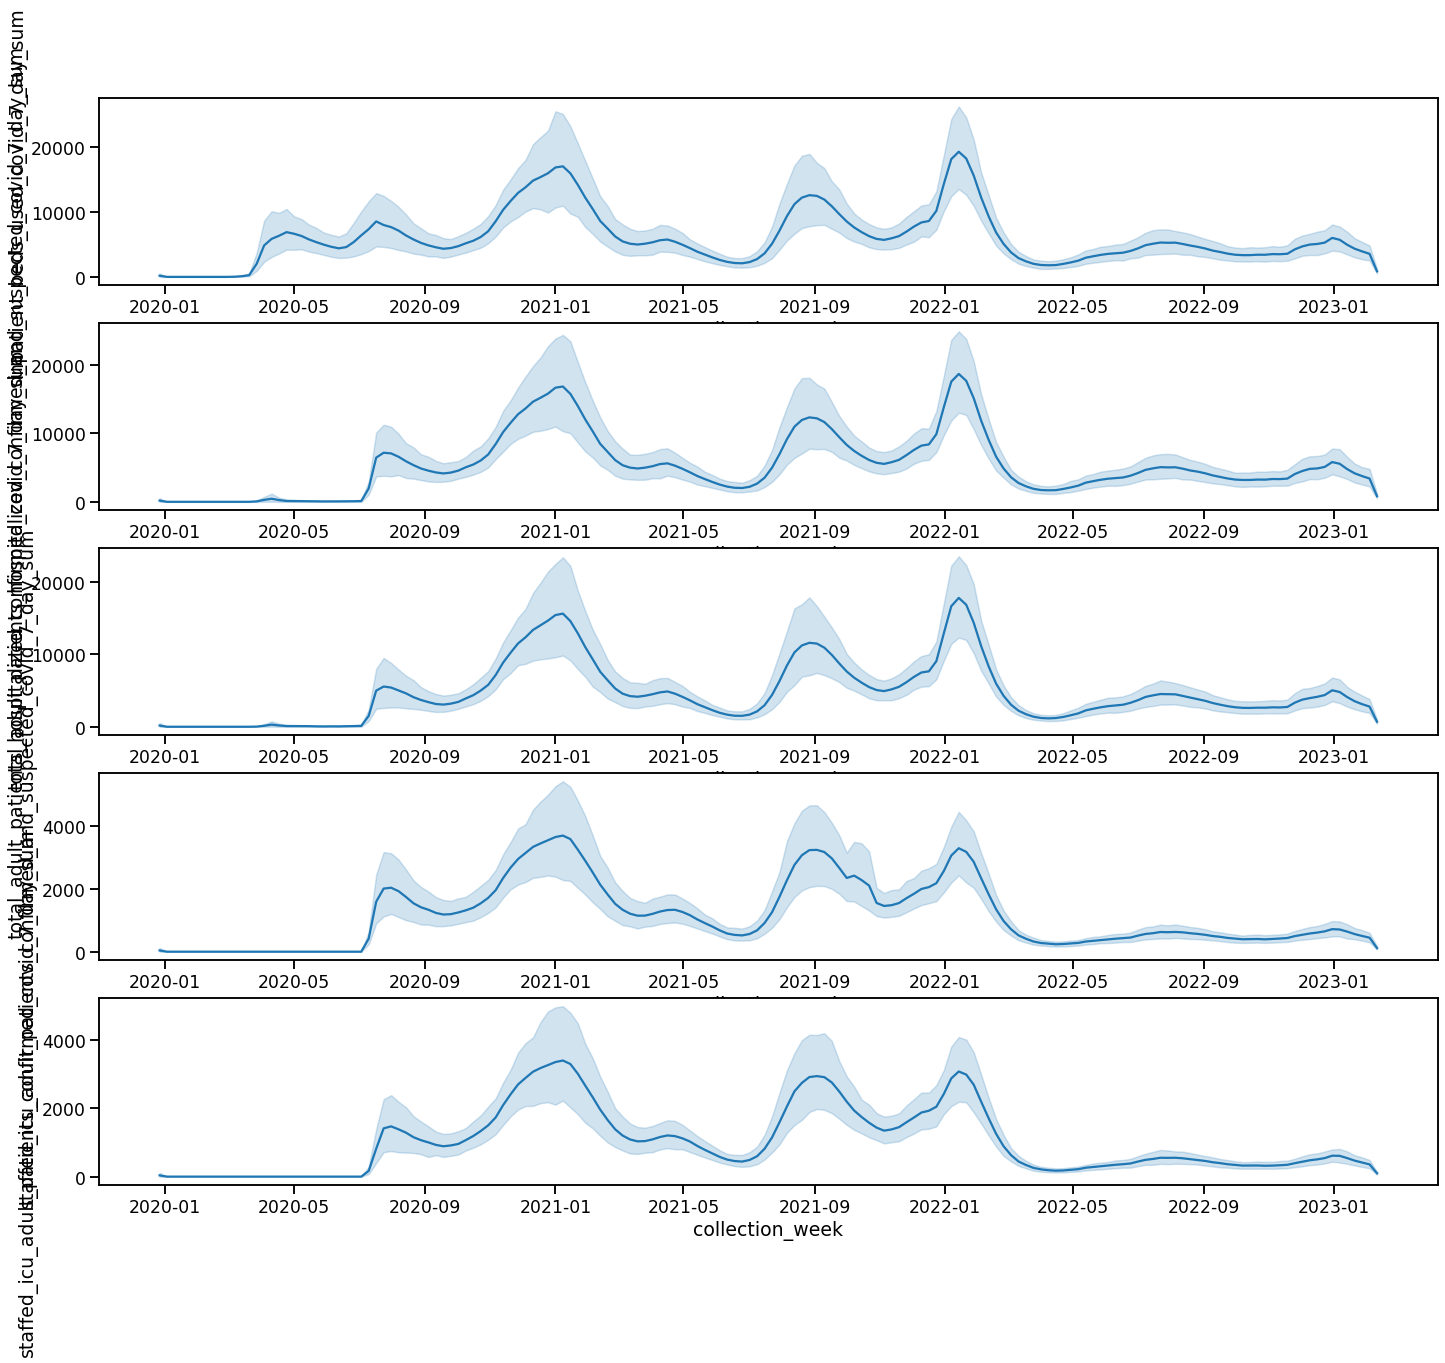

In [14]:
fig, ax = plt.subplots(figsize = (24, 20), nrows = 5, ncols = 1)
for i in range(len(sum_cols)):
    y1 = sum_cols[i]
    sns.lineplot(x = 'collection_week', y = y1, data = df_state, ax = ax[i])

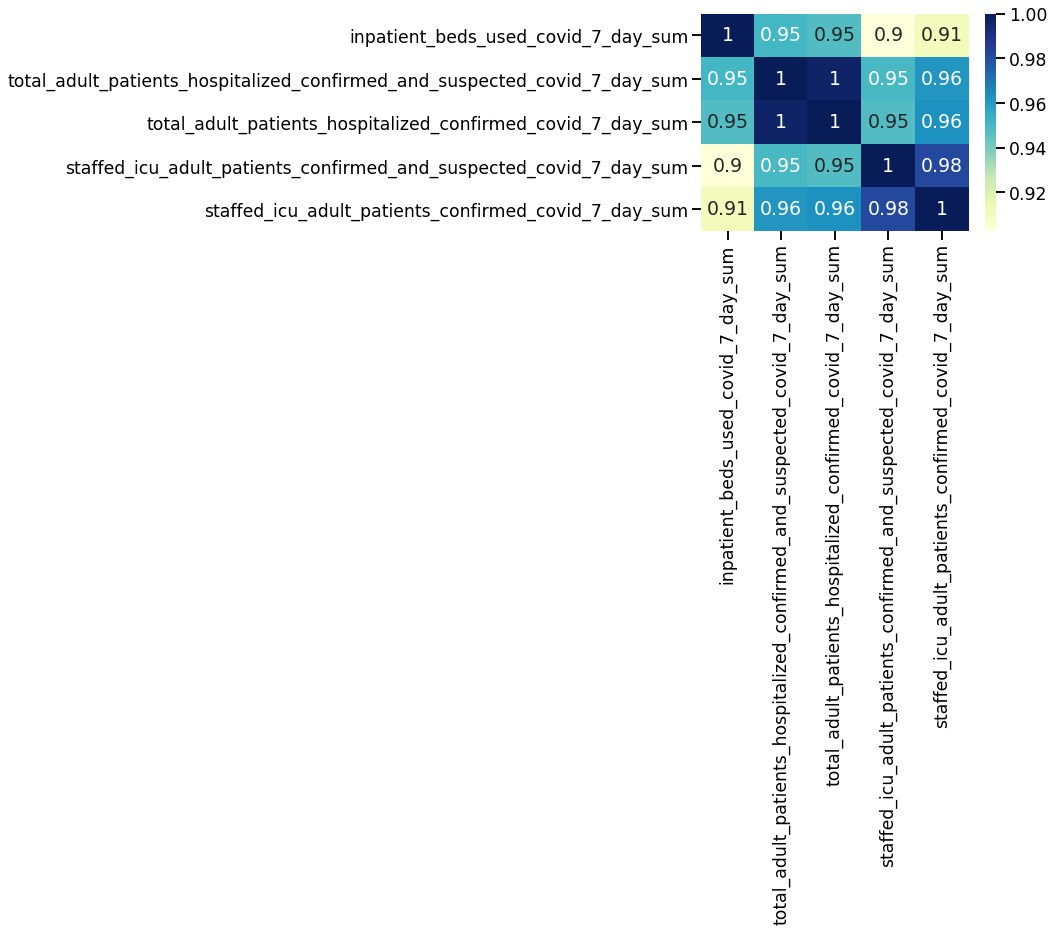

In [15]:
dataplot = sns.heatmap(df_state[sum_cols].corr(), cmap="YlGnBu", annot=True)
plt.show()

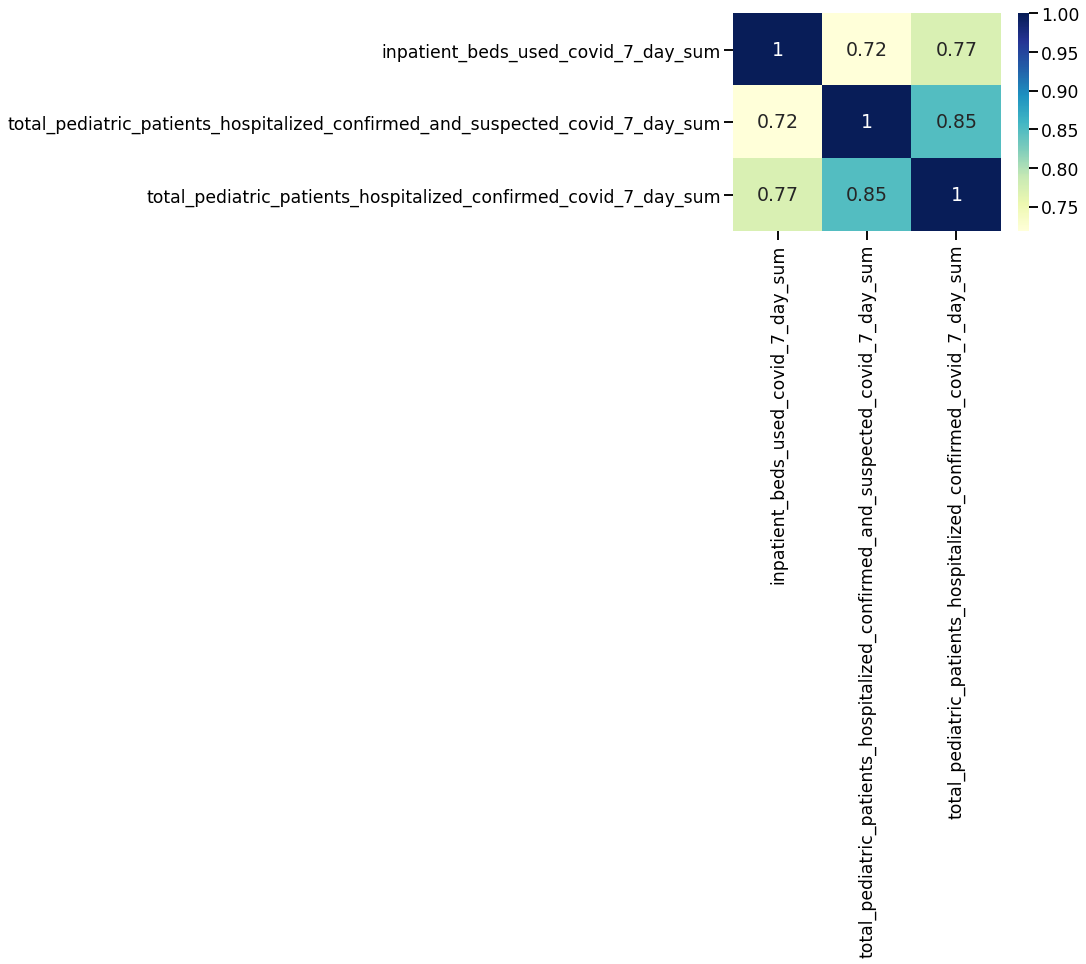

In [19]:
dataplot = sns.heatmap(df_state[sum_cols].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [23]:
sum_cols = list(df2['sum_columns'])[1:3] + list(df2['sum_columns'])[4:5] + list(df2['sum_columns'])[12:15]
sum_cols

['all_adult_hospital_beds_7_day_sum',
 'all_adult_hospital_inpatient_beds_7_day_sum',
 'all_adult_hospital_inpatient_bed_occupied_7_day_sum',
 'total_staffed_adult_icu_beds_7_day_sum',
 'icu_beds_used_7_day_sum',
 'staffed_adult_icu_bed_occupancy_7_day_sum']

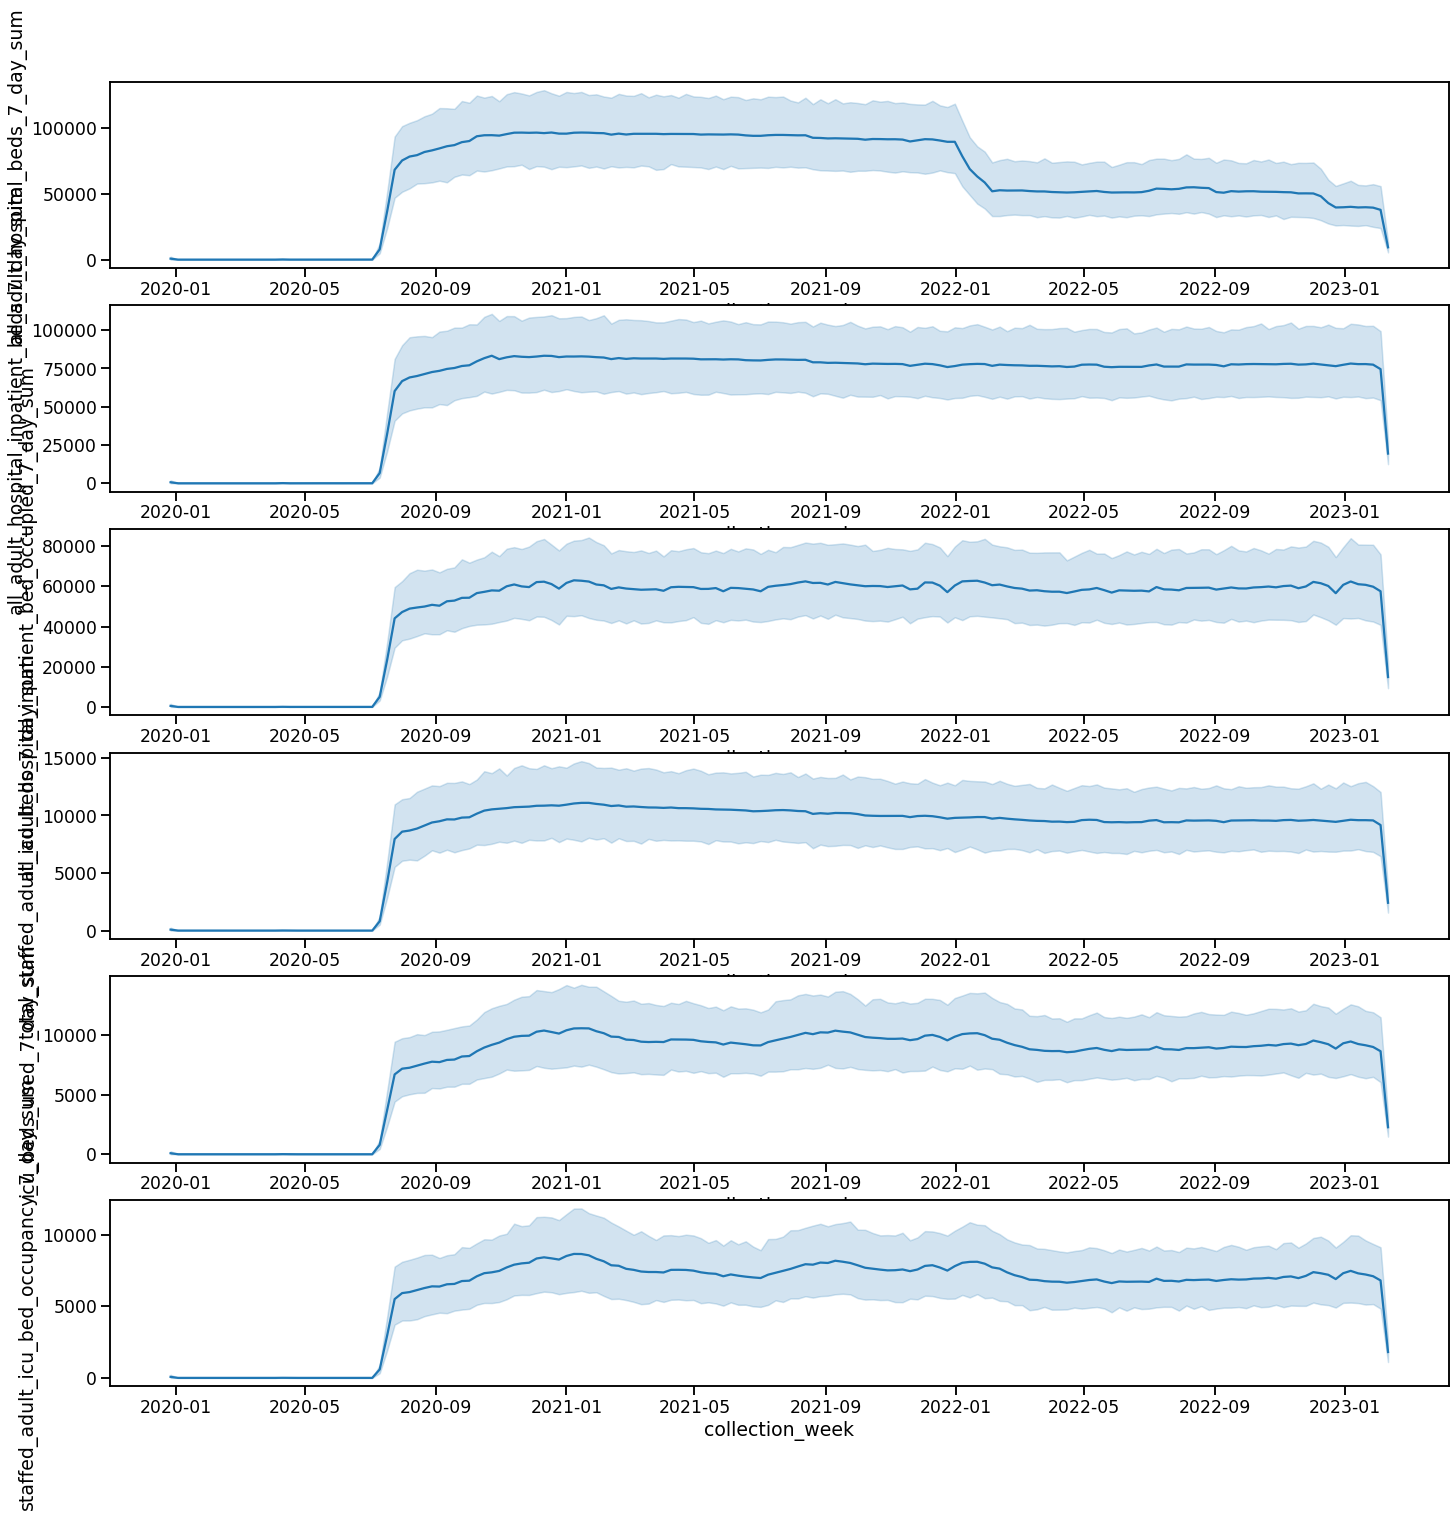

In [24]:
fig, ax = plt.subplots(figsize = (24, 24), nrows = 6, ncols = 1)
for i in range(len(sum_cols)):
    y1 = sum_cols[i]
    sns.lineplot(x = 'collection_week', y = y1, data = df_state, ax = ax[i])

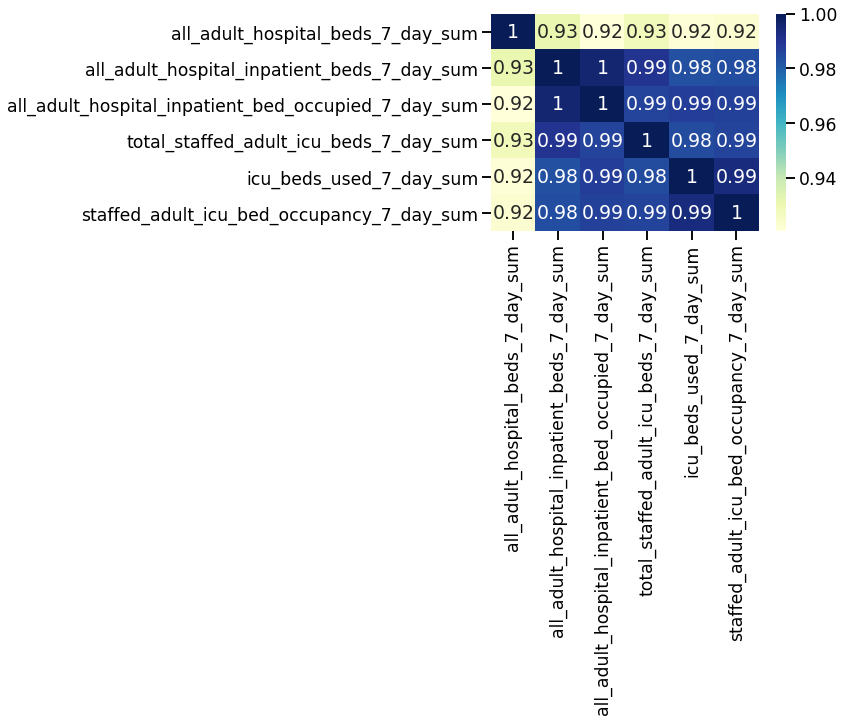

In [25]:
dataplot = sns.heatmap(df_state[sum_cols].corr(), cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
sum_cols = list(df2['sum_columns'])[1:3] + list(df2['sum_columns'])[4:5] + list(df2['sum_columns'])[12:15]
sum_cols

In [ ]:
fig, ax = plt.subplots(figsize = (24, 24), nrows = 6, ncols = 1)
for i in range(len(sum_cols)):
    y1 = sum_cols[i]
    sns.lineplot(x = 'collection_week', y = y1, data = df_state, ax = ax[i])

In [ ]:
dataplot = sns.heatmap(df_state[sum_cols].corr(), cmap="YlGnBu", annot=True)
plt.show()